# YOHO training

In [2]:
# Import used libraries

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch
torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")


from yoho24.utils import AudioClip, AudioFile, TUTDataset, YOHODataGenerator

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.1.1


In [3]:
def plot_melspectrogram(
    audio: AudioFile, n_mels: int = 40, win_len: float = 1.00, hop_len: float = 1.00
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(n_mels=n_mels, win_len=win_len, hop_len=hop_len), sr=audio.sr, x_axis="frames", y_axis="mel"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## Data generator

In [4]:
N_MELS = 40
WIN_S = 0.04 # 40 ms
HOP_S = 0.01 # 10 ms

In [5]:
audios = [
    AudioFile(filepath=file.filepath, labels=eval(file.events))
    for _, file in pd.read_csv("./data/tut.train.csv").iterrows()
]

audioclips = [
    audioclip
    for _, audio in enumerate(audios)
    for audioclip in audio.subdivide(win_len=2.56, hop_len=1.96)
    if _ < 1
]

In [6]:
audioclips[0].mel_spectrogram(n_mels=N_MELS, win_len=WIN_S, hop_len=HOP_S).shape

(40, 257)

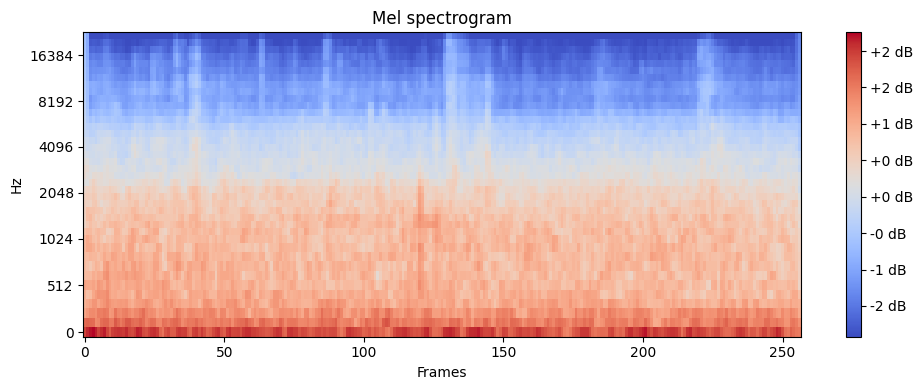

In [7]:
plot_melspectrogram(audioclips[1], n_mels=N_MELS, win_len=WIN_S, hop_len=HOP_S)

In [8]:
N_MELS = 40
HOP_MS = 10
WIN_MS = 40

tut_train = TUTDataset(
    audios=audioclips,
)

print(f"Number of audio files: {len(tut_train)}")
print(f"Duration: {tut_train.audios[0].duration} seconds")
print(f"Sampling rate: {tut_train.audios[0].sr} Hz")

Number of audio files: 122
Duration: 2.56 seconds
Sampling rate: 44100 Hz


In [9]:
train_dataloader = YOHODataGenerator(tut_train, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train features shape: torch.Size([1, 1, 257, 40])
Train labels shape: torch.Size([1, 9, 18])


In [10]:
import numpy as np

mel = np.zeros((257, 40))
mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

from models import YOHO

prediction = YOHO(input_shape=(1, 257, 40), output_shape=(9,18))(mel)
prediction.shape

torch.Size([1, 9, 18])

In [11]:
from torchsummary import summary

summary(YOHO(input_shape=(1, 257, 40), output_shape=(18,9)), (1, 257, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 129, 20]             288
       BatchNorm2d-2          [-1, 32, 129, 20]              64
              ReLU-3          [-1, 32, 129, 20]               0
            Conv2d-4          [-1, 32, 129, 20]             288
       BatchNorm2d-5          [-1, 32, 129, 20]              64
              ReLU-6          [-1, 32, 129, 20]               0
            Conv2d-7          [-1, 64, 129, 20]           2,048
       BatchNorm2d-8          [-1, 64, 129, 20]             128
              ReLU-9          [-1, 64, 129, 20]               0
          Dropout-10          [-1, 64, 129, 20]               0
DepthwiseSeparableConv-11          [-1, 64, 129, 20]               0
           Conv2d-12           [-1, 64, 65, 10]             576
      BatchNorm2d-13           [-1, 64, 65, 10]             128
             ReLU-14           [-1